In [1]:
import time
import xarray as xr
import numpy as np

from xcube.core.geocoded import reproject_dataset, compute_output_geom
from xcube.core.sentinel3 import open_sentinel3_product
from xcube.util.perf import measure_time

In [2]:
path = 'C:\\Users\\Norman\\Downloads\\S3B_OL_1_EFR____20190728T103451_20190728T103751_20190729T141105_0179_028_108_1800_LN1_O_NT_002.SEN3'

Define a fake-logger. The normal logger output does not appear in notebooks.

In [3]:
class Logger:
    info = print
logger = Logger()

---
Open a Sentinel-3 OLCI L1b product:

In [4]:
src_ds = open_sentinel3_product(path)

Preload x,y coordinates so we are faster:

In [5]:
src_ds.longitude.load()
src_ds.latitude.load()
src_ds

<xarray.Dataset>
Dimensions:         (columns: 4865, rows: 4091)
Dimensions without coordinates: columns, rows
Data variables:
    longitude       (rows, columns) float64 -10.55 -10.54 -10.53 ... 12.07 12.07
    latitude        (rows, columns) float64 73.35 73.35 73.35 ... 59.96 59.96
    Oa15_radiance   (rows, columns) float32 dask.array<chunksize=(1023, 1217), meta=np.ndarray>
    Oa21_radiance   (rows, columns) float32 dask.array<chunksize=(1023, 1217), meta=np.ndarray>
    quality_flags   (rows, columns) uint32 dask.array<chunksize=(819, 973), meta=np.ndarray>
    Oa06_radiance   (rows, columns) float32 dask.array<chunksize=(1023, 1217), meta=np.ndarray>
    Oa02_radiance   (rows, columns) float32 dask.array<chunksize=(1023, 1217), meta=np.ndarray>
    Oa14_radiance   (rows, columns) float32 dask.array<chunksize=(1023, 1217), meta=np.ndarray>
    Oa13_radiance   (rows, columns) float32 dask.array<chunksize=(1023, 1217), meta=np.ndarray>
    Oa12_radiance   (rows, columns) float32 dask.array<chunksize=(1023, 1217), meta=np.ndarray>
    Oa01_radiance   (rows, columns) float32 dask.array<chunksize=(1023, 1217), meta=np.ndarray>
    Oa05_radiance   (rows, columns) float32 dask.array<chunksize=(1023, 1217), meta=np.ndarray>
    Oa19_radiance   (rows, columns) float32 dask.array<chunksize=(1023, 1217), meta=np.ndarray>
    Oa18_radiance   (rows, columns) float32 dask.array<chunksize=(1023, 1217), meta=np.ndarray>
    Oa04_radiance   (rows, columns) float32 dask.array<chunksize=(1023, 1217), meta=np.ndarray>
    Oa08_radiance   (rows, columns) float32 dask.array<chunksize=(1023, 1217), meta=np.ndarray>
    Oa09_radiance   (rows, columns) float32 dask.array<chunksize=(1023, 1217), meta=np.ndarray>
    Oa17_radiance   (rows, columns) float32 dask.array<chunksize=(1023, 1217), meta=np.ndarray>
    Oa10_radiance   (rows, columns) float32 dask.array<chunksize=(1023, 1217), meta=np.ndarray>
    Oa20_radiance   (rows, columns) float32 dask.array<chunksize=(1023, 1217), meta=np.ndarray>
    Oa11_radiance   (rows, columns) float32 dask.array<chunksize=(1023, 1217), meta=np.ndarray>
    Oa07_radiance   (rows, columns) float32 dask.array<chunksize=(1023, 1217), meta=np.ndarray>
    Oa16_radiance   (rows, columns) float32 dask.array<chunksize=(1023, 1217), meta=np.ndarray>
    Oa03_radiance   (rows, columns) float32 dask.array<chunksize=(1023, 1217), meta=np.ndarray>
    detector_index  (rows, columns) float32 dask.array<chunksize=(1023, 1217), meta=np.ndarray>

In [6]:
src_ds.Oa13_radiance.plot.imshow(figsize=(16,16), vmax=40, cmap='Greys_r')

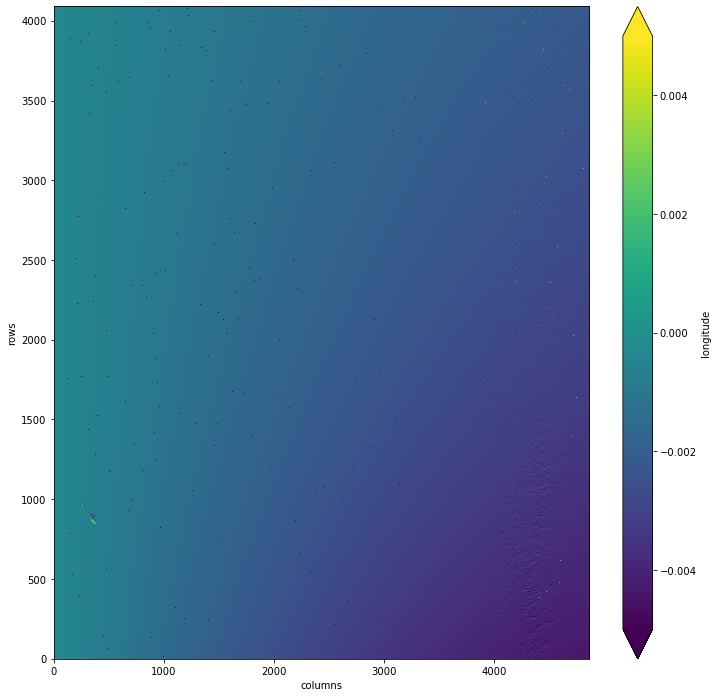

In [7]:
src_ds.longitude.diff('rows').plot.imshow(figsize=(12,12), vmin=-0.005, vmax=0.005)

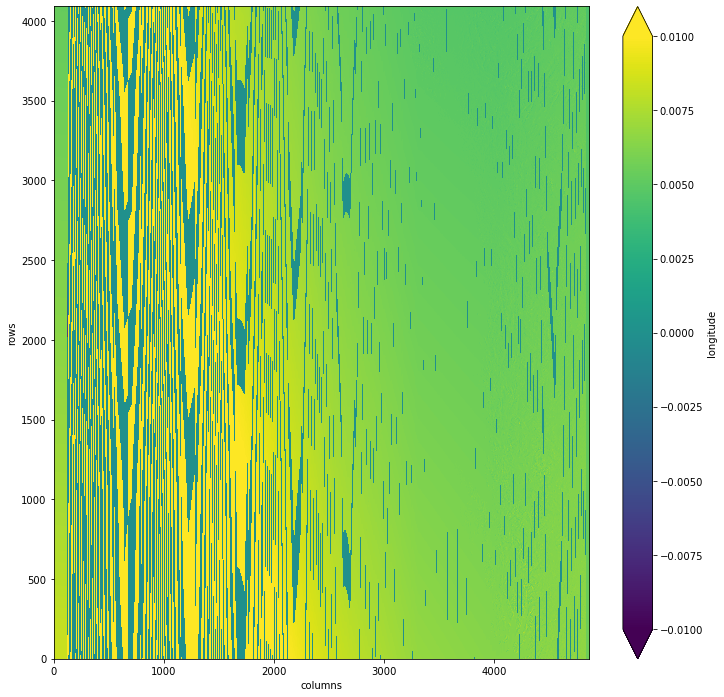

In [8]:
src_ds.longitude.diff('columns').plot.imshow(figsize=(12,12), vmin=-0.01, vmax=0.01)

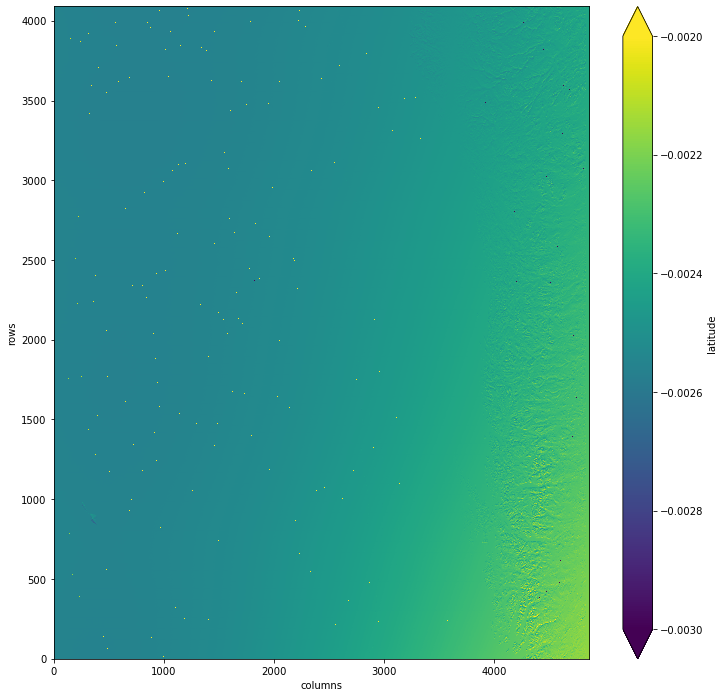

In [9]:
src_ds.latitude.diff('rows').plot.imshow(figsize=(12,12), vmin=-0.003, vmax=-0.002)

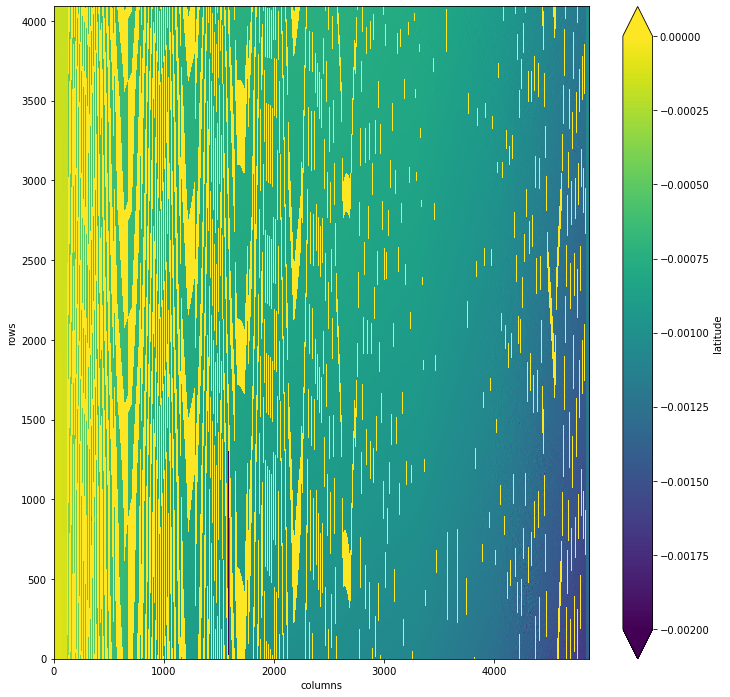

In [10]:
src_ds.latitude.diff('columns').plot.imshow(figsize=(12,12), vmin=-0.002, vmax=0.0)

In [11]:
col_diff = np.sqrt(np.square(src_ds.longitude.diff('columns')) + np.square(src_ds.latitude.diff('columns'))) 
col_diff

<xarray.DataArray (rows: 4091, columns: 4864)>
array([[0.00843351, 0.00843451, 0.0084335 , ..., 0.00578544, 0.00578423,
        0.00578447],
       [0.00843251, 0.00843251, 0.0084325 , ..., 0.00578544, 0.00578423,
        0.00578447],
       [0.00843051, 0.00843151, 0.0084315 , ..., 0.00578326, 0.00578447,
        0.00578423],
       ...,
       [0.00530347, 0.00530444, 0.00530344, ..., 0.00451173, 0.00451098,
        0.00451173],
       [0.00530344, 0.00530244, 0.00530347, ..., 0.00451076, 0.00451098,
        0.00451173],
       [0.00530244, 0.00530244, 0.00530344, ..., 0.00451076, 0.00451098,
        0.00451076]])
Dimensions without coordinates: rows, columns

In [12]:
row_diff = np.sqrt(np.square(src_ds.longitude.diff('rows')) + np.square(src_ds.latitude.diff('rows'))) 
row_diff

<xarray.DataArray (rows: 4090, columns: 4865)>
array([[0.00256934, 0.00256946, 0.00256969, ..., 0.00487873, 0.00487873,
        0.00487873],
       [0.00256934, 0.00256957, 0.00256969, ..., 0.00487963, 0.00488007,
        0.00487963],
       [0.00256934, 0.00256946, 0.00256969, ..., 0.00487559, 0.00487604,
        0.00487648],
       ...,
       [0.00257784, 0.00257897, 0.00257897, ..., 0.00327525, 0.00327592,
        0.00327592],
       [0.00257883, 0.00257784, 0.00257812, ..., 0.00327592, 0.00327592,
        0.00327592],
       [0.00257883, 0.00257897, 0.00257897, ..., 0.00327525, 0.00327525,
        0.00327592]])
Dimensions without coordinates: rows, columns

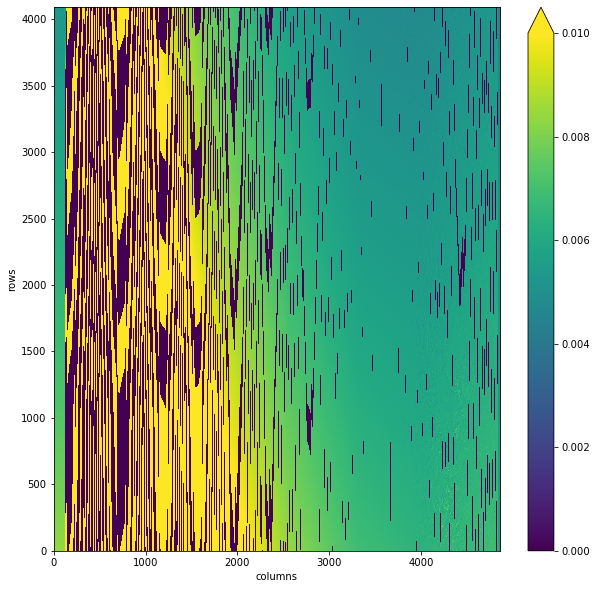

In [13]:
col_diff.plot.imshow(figsize=(10,10), vmin=0.0, vmax=0.01)

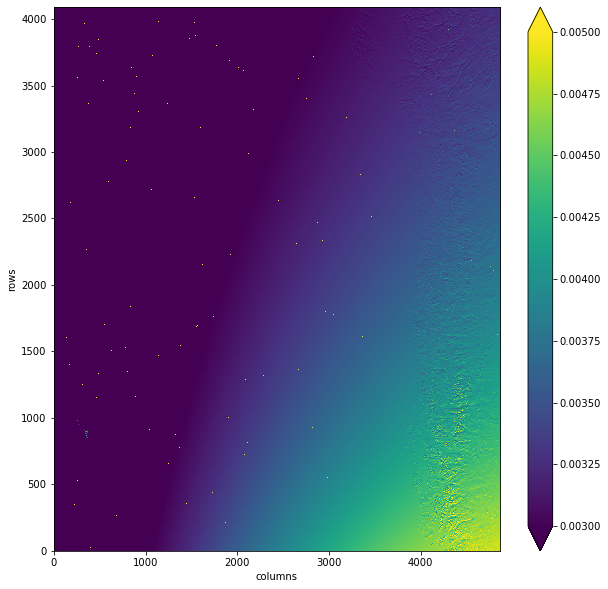

In [14]:
row_diff.plot.imshow(figsize=(10,10), vmin=0.003, vmax=0.005)

---
Compute image geometry for output:

In [15]:
with measure_time(tag='compute_output_geom', logger=logger):
    og = compute_output_geom(src_ds)

compute_output_geom: took 3219.28ms


In [16]:
og.size, og.is_tiled

((20259, 7386), False)

---
Reproject the dataset in-memory:

In [17]:
with measure_time(tag='reproject_dataset', logger=logger):
    dst_ds = reproject_dataset(src_ds, var_names='Oa13_radiance')

loading x,y took 0.00011289999999775091 seconds
reproject_dataset: took 35480.18ms


In [18]:
dst_ds

<xarray.Dataset>
Dimensions:        (latitude: 7386, longitude: 20259)
Coordinates:
  * longitude      (longitude) float64 -11.92 -11.92 -11.92 ... 24.82 24.82
  * latitude       (latitude) float64 59.96 59.96 59.96 ... 73.35 73.35 73.35
Data variables:
    Oa13_radiance  (latitude, longitude) float32 nan nan nan nan ... nan nan nan

In [19]:
Oa13_radiance = dst_ds.Oa13_radiance

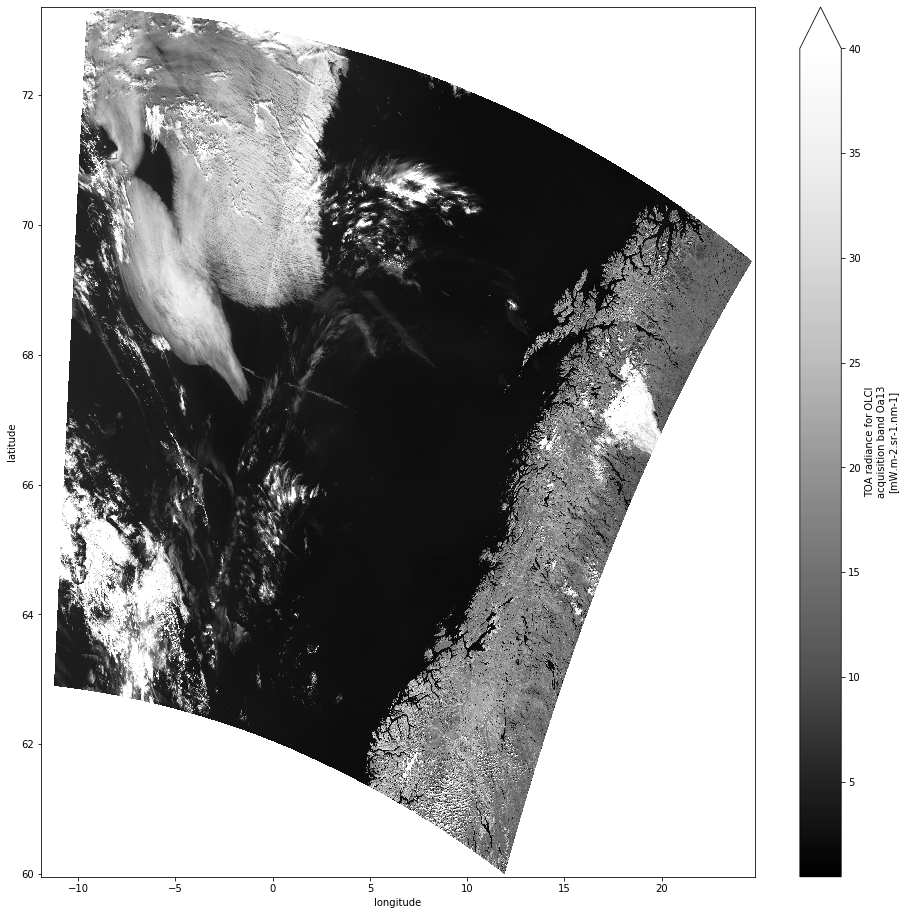

In [20]:
Oa13_radiance.plot.imshow(figsize=(16,16), vmax=40, cmap='Greys_r')

## Creating subsets from source `longitude` and `latitude` using a bounding box `bbox`

Bounding box `bbox` in decimal degree:

In [ ]:
bbox = (5, 62, 7, 64)

Compute `src_bbox` by selecting pixels in `bbox`:

In [ ]:
src_bbox = np.logical_and(np.logical_and(src_ds.longitude >= bbox[0], src_ds.longitude <= bbox[2]), 
                          np.logical_and(src_ds.latitude >= bbox[1], src_ds.latitude <= bbox[3]))
src_bbox.plot.imshow()

Select pixel coordinates from coordinate variables `x`, `y` using selected pixels in `src_bbox`:

In [ ]:
x = src_ds.columns.where(src_bbox)
y = src_ds.rows.where(src_bbox)

In [ ]:
x.plot.imshow()

In [ ]:
y.plot.imshow()

Get new bouning box `(x1, y1, x2, y2)` in pixel coordinates from min/max of `x` and `y`:

In [ ]:
x1 = int(x.min())
x2 = int(x.max())
y1 = int(y.min())
y2 = int(y.max())

In [ ]:
x1, y1, x2, y2

Use bounding box `(x1, y1, x2, y2)` to select subset within source image:

In [ ]:
rad = src_ds.Oa13_radiance.isel(columns=slice(x1, x2 + 1), rows=slice(y1, y2 + 1))
rad

In [ ]:
rad.plot.imshow(figsize=(10,10), vmax=40, cmap='Greys_r')

Verify: use bounding box `bbox` to select subset within target image:

In [ ]:
rad = dst_ds.Oa13_radiance.sel(longitude=slice(bbox[0], bbox[2]), latitude=slice(bbox[1], bbox[3]))
rad

In [ ]:
rad.plot.imshow(figsize=(10,10), vmax=40, cmap='Greys_r')